### Visualização e Análise das Imagens

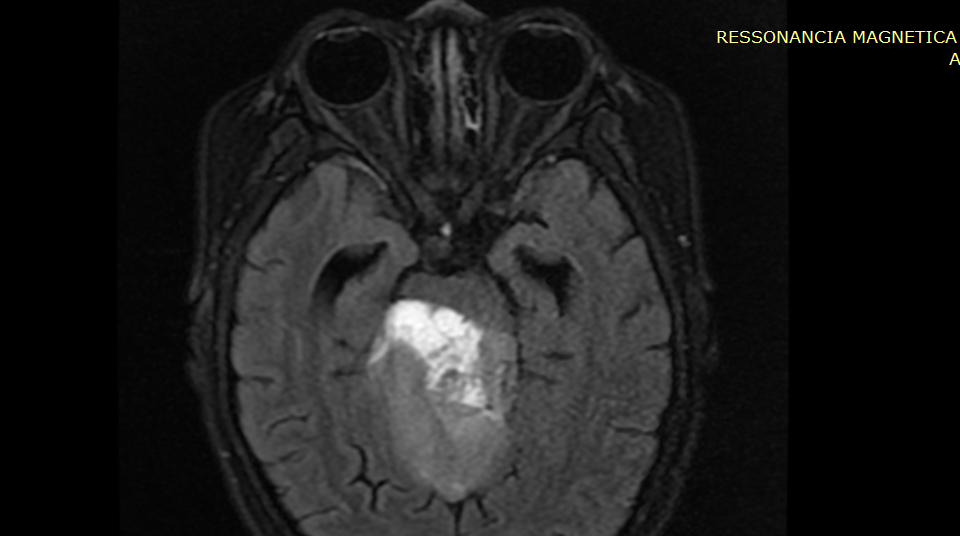

- Foi utilizado o programa RadiAnt DICOM Viewer para visualizar as imagens .dcm

- Foram selecionadas 28 imagens para compor os frames (0-27)

***

### Conversão de arquivos .dcm para um arquivo .tif

In [ ]:
import pydicom
from PIL import Image
import glob

# Função para converter os arquivos
def convert_dcm_to_tif(dcm_dir, start_num, end_num, output_file):
    """
    Converte um conjunto de imagens DICOM em um único arquivo TIFF.

    Args:
        dcm_dir (str): Caminho para o diretório das imagens DICOM.
        start_num (int): Número inicial da sequência de imagens.
        end_num (int): Número final da sequência de imagens.
        output_file (str): Caminho para o arquivo TIFF de saída.
    """

    images = []
    for i in range(start_num, end_num + 1):
        file_path = f"{dcm_dir}/{i}.dcm"
        ds = pydicom.dcmread(file_path)
        img = ds.pixel_array
        pil_img = Image.fromarray(img)
        images.append(pil_img)

    images[0].save(output_file, "TIFF", save_all=True, append_images=images[1:])

# Configuração
dcm_dir = "Axial T2"  # Diretório das imagens
start_num = 0
end_num = 27
output_file = "all_images_T2.tif"

# Chamada da função
convert_dcm_to_tif(dcm_dir, start_num, end_num, output_file)

******

### Verificar como os dados estão estruturados no arquivo.tif

In [ ]:
import numpy as np
from skimage import io

# Carregar o arquivo .tif com 101 slides (imagens)
vol = io.imread("all_images_T2.tif")
volume = vol.T  # Transpor para garantir que as fatias estejam na ordem correta

# Verificar a forma do volume
print(volume.shape)

******

### Redimensionar o arquivo .tif para acelerar os frames

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage import io

# Carrega a imagem MRI
img = imread('all_images_T2.tif')

# Reduz a imagem para metade da resolução original
img_resized = resize(img, (img.shape[0] // 2, img.shape[1] // 2),
                       anti_aliasing=True)

# Salva a imagem redimensionada
io.imsave('all_images_T2_resized.tif', img_resized)

******

### Gráfico Medullo 3D

In [ ]:
# Importar os as bibliotecas e os dados
import time
import numpy as np
from skimage import io
import plotly.graph_objects as go

vol = io.imread("all_images_T2_resized.tif")
volume = np.transpose(vol, (0, 2, 1))
r, c = volume[0].shape

# Calcular o mínimo e máximo dos dados para ajustar a escala de cor
vmin = np.min(volume)
vmax = np.max(volume)

# Definir o número de frames igual ao número de slices disponíveis no volume (50)
nb_frames = volume.shape[0]

# Criar o gráfico interativo
fig = go.Figure(frames=[go.Frame(data=go.Surface(
    z=(6.7 - k * 0.3) * np.ones((r, c)),
    surfacecolor=np.flipud(volume[volume.shape[0] - 1 - k]),  # Ajustando para os índices válidos
    cmin=vmin, cmax=vmax,
    colorscale='Gray'
    ),
    name=str(k)
    )
    for k in range(nb_frames)])

# Adiciona a surface inicial, que é o primeiro frame (slice 49 neste caso)
fig.add_trace(go.Surface(
    z=6.7 * np.ones((r, c)),
    surfacecolor=np.flipud(volume[0]),
    colorscale='Gray',
    cmin=vmin, cmax=vmax,
    showscale=False  # Remove a barra de cores
))

# Layout e configuração de animação
def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(10)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

fig.update_layout(
    title={
        'text': "Ectopic Medulloblastoma Located in the Pineal Region (Axial Plane)",
        'y': 0.95,  # Ajuste a posição vertical do título (1.0 = topo)
        'x': 0.5,   # Centraliza o título horizontalmente
        'xanchor': 'center',
        'yanchor': 'top',
        'pad': {'b': 20}  # Adiciona um espaçamento inferior para o título
    },
    width=600,
    height=600,
    scene=dict(
        zaxis=dict(range=[-0.1, 6.8], autorange=False),
        aspectratio=dict(x=1, y=1, z=1),
    ),
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, frame_args(250)],
                    "label": "&#9654;",  # símbolo de play
                    "method": "animate",
                },
                {
                    "args": [[None], frame_args(0)],
                    "label": "&#9724;",  # símbolo de pausa
                    "method": "animate",
                },
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 70},
            "type": "buttons",
            "x": 0.1,
            "y": 0,
        }
    ],
    sliders=sliders
)

fig.show()

******

### Salvar em HTML

In [ ]:
fig.write_html('index.html')

******